# Part 2: prior predictive check

In [1]:
# To install necessary package
install.packages("outbreaks")

Installing package into 'C:/Users/Jiheo/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'outbreaks' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Jiheo\AppData\Local\Temp\RtmpKEpeEm\downloaded_packages


In [2]:
# To load necessary packages
library(outbreaks)
library(cmdstanr)
library(tidybayes)
library(data.table)
library(stringr)
library(ggplot2)


This is cmdstanr version 0.9.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: C:/Users/Jiheo/.cmdstan/cmdstan-2.36.0

- CmdStan version: 2.36.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.



In [3]:
# To load functions
source("sir_func.r")

In [4]:
# To define input data
N <- 763
cases <- influenza_england_1978_school$in_bed
n_days <- length(cases)
t0 <- 0
t <- seq(from = 0, to = n_days, by = 1)
t <- t[-1] # To remove element 1

# To define initial conditions
s0 <- N - 1
i0 <- 1
r0 <- 0
y0 <- c(S = s0, I = i0, R = r0)

# To create a list of input data
sir_data <- list(n_days = n_days, y0 = y0, t0 = t0,
                 ts = t, N = N, cases = cases, compute_likelihood = 0)

In [5]:
# To compile & fit Stan model
sir_v2_fit <- fit_model("sir_v2", sir_data)

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpAp3AHS/model-9358bd51693.stan', line 37, column 4 to column 74)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ode_rk45:  Failed to integrate to next output time (1) in less than max_num_steps steps (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpAp3AHS/model-9358bd51693.stan', line 37, column 4 to column 74)

Chain 4 If this warning occurs sporadically, such as for highl

In [6]:
# To inspect summary of model fit
sir_parm <- c("beta", "gamma", "phi")
sir_pred_qtys <- c("R0", "recovery_time")
sir_v2_summ <- sir_v2_fit$summary(c(sir_parm, sir_pred_qtys))
print(sir_v2_summ)

# A tibble: 5 × 10
  variable       mean median      sd   mad     q5    q95  rhat ess_bulk ess_tail
  <chr>         <dbl>  <dbl>   <dbl> <dbl>  <dbl>  <dbl> <dbl>    <dbl>    <dbl>
1 beta          2.08   2.05    0.934 0.974 0.608    3.71  1.00    1590.     683.
2 gamma         0.578  0.526   0.379 0.410 0.0506   1.26  1.00    1239.     810.
3 phi          46.5    7.33  385.    6.87  1.66   110.    1.00    1328.     847.
4 R0           16.9    3.72  137.    2.97  0.904   40.2   1.00     983.     890.
5 recovery_ti…  9.55   1.90  113.    1.27  0.792   19.8   1.00    1239.     810.


In [7]:
# To retrieve predicted quantities
sir_v2_pred_qtys <- data.table(spread_draws(sir_v2_fit, R0, recovery_time))

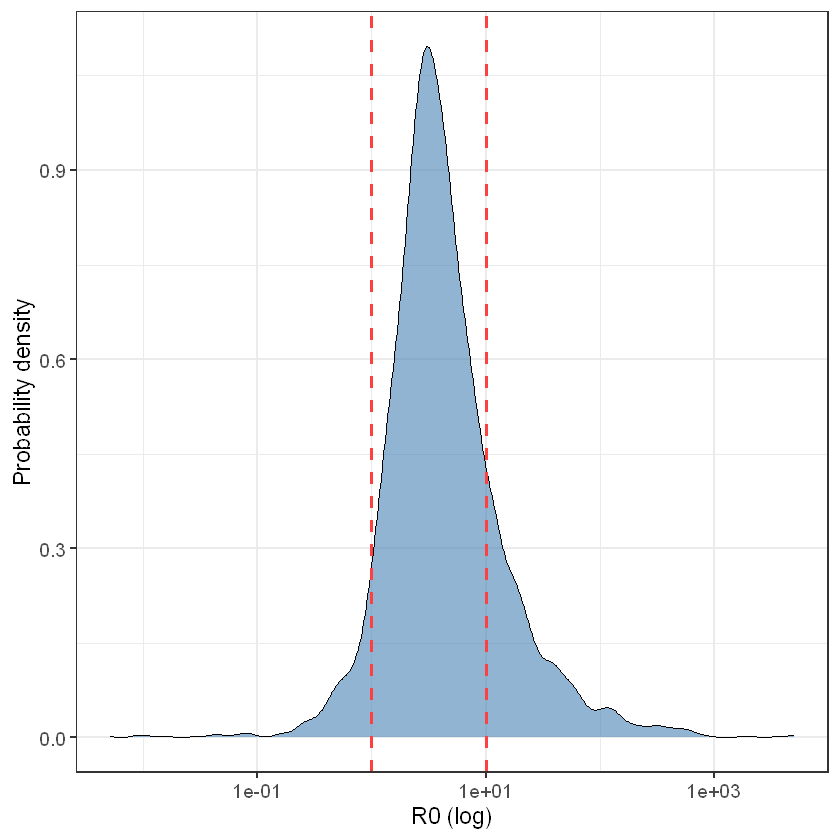

In [8]:
# To plot R0 distribution based on priors
ggplot(data = sir_v2_pred_qtys) +
geom_density(aes(x = R0), fill = "steelblue", alpha = 0.6) +
geom_vline(xintercept = c(1, 10), color = "brown1", linetype = 2, linewidth = 1) +
scale_x_log10() +
labs(x = "R0 (log)", y = "Probability density") +
theme_bw(base_size = 14)


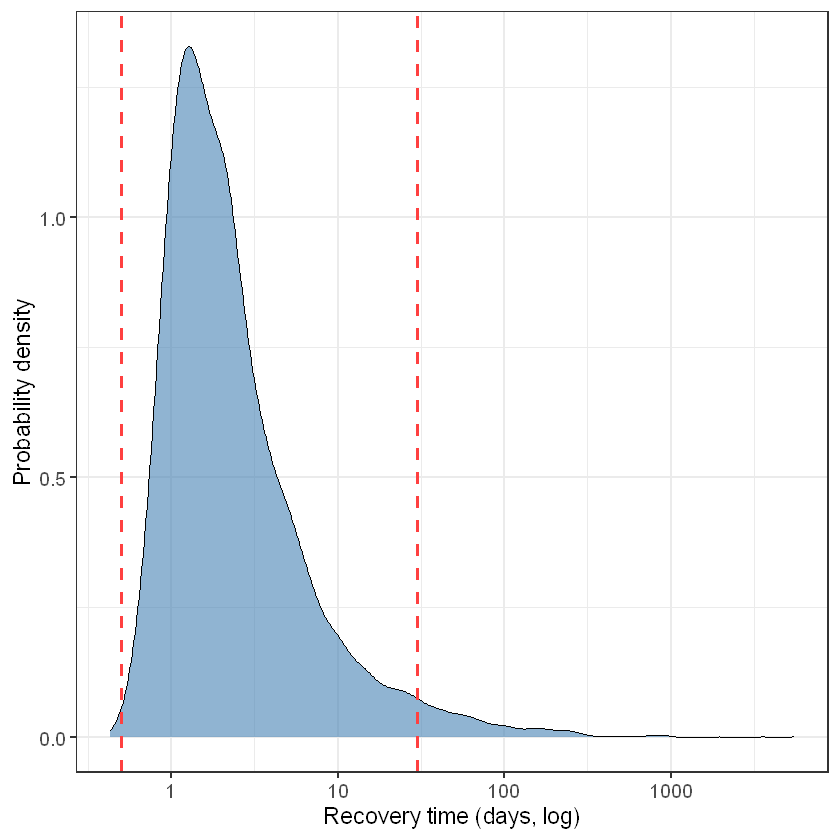

In [9]:
# To plot recovery_time distribution based on priors
ggplot(data = sir_v2_pred_qtys) +
geom_density(aes(x = recovery_time), fill = "steelblue", alpha = 0.6) +
geom_vline(xintercept = c(0.5, 30), color = "brown1", linetype = 2, linewidth = 1) +
scale_x_log10() +
labs(x = "Recovery time (days, log)", y = "Probability density") +
theme_bw(base_size = 14)

In [10]:
# To retrieve no. of infected students
sir_v2_inf <- data.table(spread_draws(sir_v2_fit, y[time, state]))[state == 2] |>
  remove_dots()

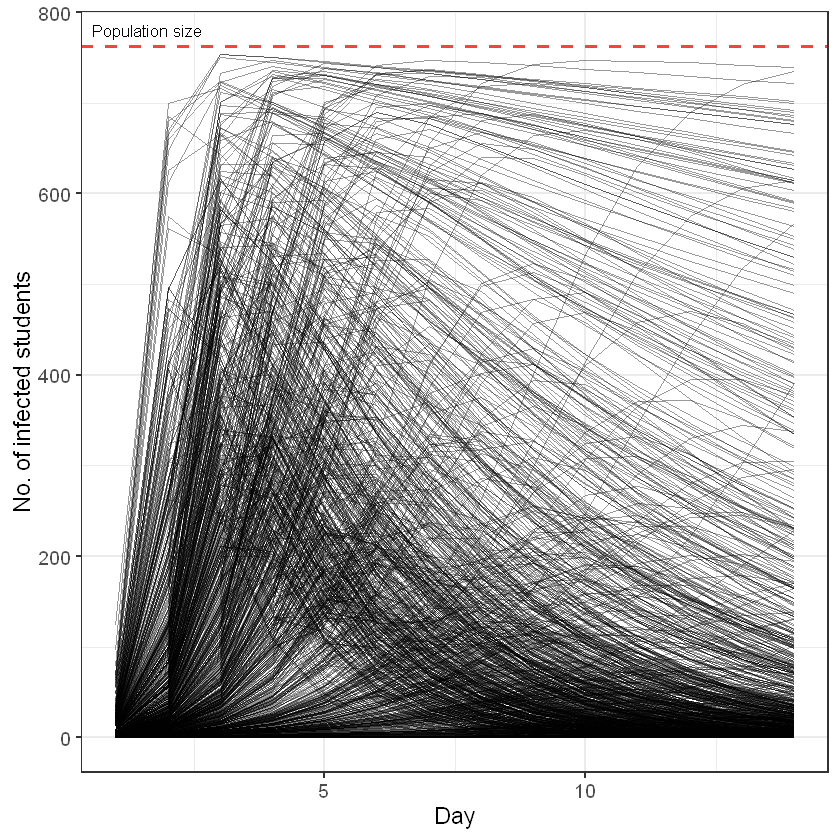

In [11]:
# To plot no. of infected students based on priors
sir_v2_inf_1000 <- sir_v2_inf[draw <= 1000]
ggplot(data = sir_v2_inf_1000) +
 geom_line(mapping = aes(x = time, y = y, group = draw), linewidth = 0.4, alpha = 0.4) +
 geom_hline(yintercept = 763, color = "brown1", linewidth = 1, linetype = "dashed") +
 geom_text(x = 1.6, y = 781, label = "Population size", size = 3.5) +
 labs(x = "Day", y = "No. of infected students") +
 theme_bw(base_size = 14)

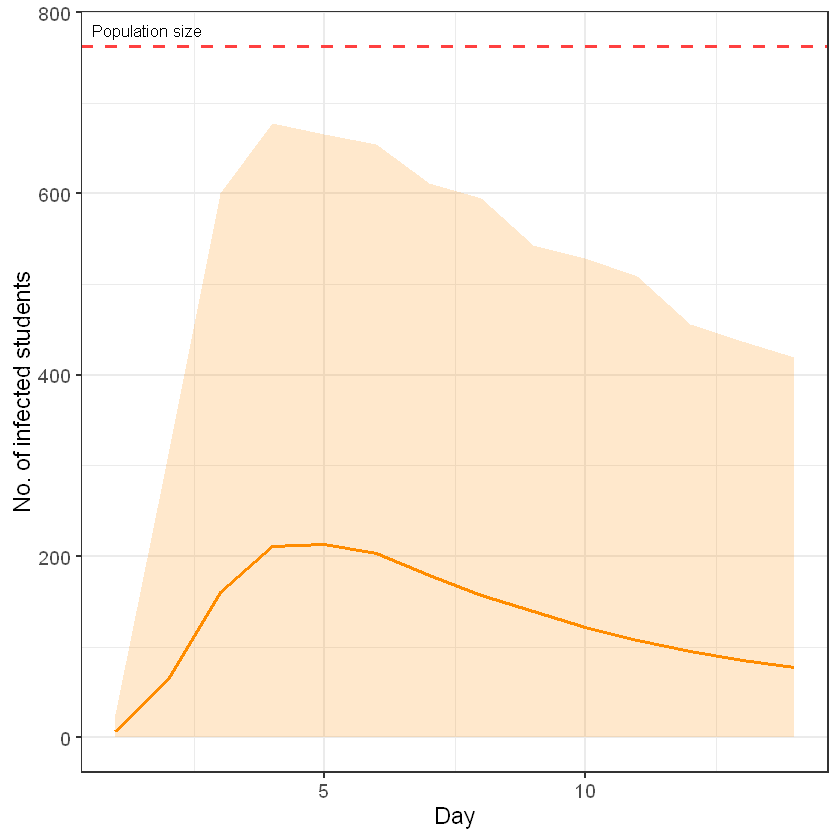

In [12]:
# To plot no. of infected students based on priors
sir_v2_pred_summ <- data.table(sir_v2_fit$summary(variables = "pred_cases"))|>
subset(select = c("mean", "q5", "q95")) |> cbind(t)
ggplot(data = sir_v2_pred_summ, mapping = aes(x = t)) +
geom_ribbon(aes(ymin = q5, ymax = q95), fill = "darkorange", alpha = 0.2) +
geom_line(mapping = aes(x = t, y = mean), color = "darkorange", linewidth = 1) +
geom_hline(yintercept = 763, color = "brown1", linewidth = 1, linetype = "dashed") +
geom_text(x = 1.6, y = 781, label = "Population size", size = 3.5) +
labs(x = "Day", y = "No. of infected students") +
theme_bw(base_size = 14)